# Assignment on Resource Planning

## Online gradient technique

In [521]:
#Import libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

### Data
Load Data

In [522]:
df = pd.read_csv("Twitter_volume_AMZN.csv", sep=',', header=0, parse_dates=['timestamp'],index_col='timestamp')
df

,value
timestamp,
2015-02-26 21:42:53,57
2015-02-26 21:47:53,43
2015-02-26 21:52:53,55
2015-02-26 21:57:53,64
2015-02-26 22:02:53,93
...,...
2015-04-22 20:32:53,51
2015-04-22 20:37:53,54
2015-04-22 20:42:53,46


Compute and plot Hourly Tweet

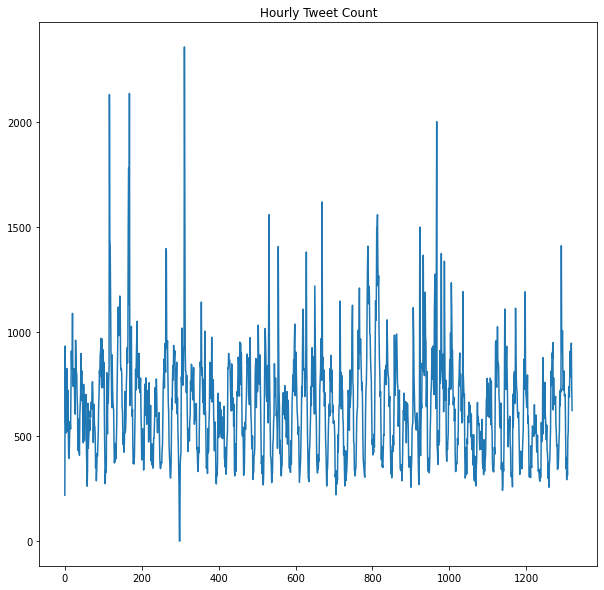

In [523]:
df.index = df.index.map(lambda x: x.replace(minute=0,second=0))
df_hourly_count = df.groupby(df.index)['value'].sum()
plt.figure(figsize = (10,10))
plt.plot(df_hourly_count.values)
plt.title('Hourly Tweet Count')
plt.savefig('hourly_count.png', dpi=1000)

### Check Stationarity

A time series is said to be stationary if its statistical properties such as mean, variance remain constant over time. 
The reason why we verify time series stationarity is because we cannot build a time series model if the time series is not stationary.
Let's verify that the time series is stationary.

To do so, we will use the rolling statistics plots along with Dickey-Fuller test results.

In [545]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    '''
    Input: timeseries (dataframe): timeseries for which we want to study the stationarity
    '''
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
#     plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',\
                                             '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -3.354819
p-value                           0.012599
#Lags Used                       23.000000
Number of Observations Used    1296.000000
Critical Value (1%)              -3.435406
Critical Value (5%)              -2.863773
Critical Value (10%)             -2.567959
dtype: float64


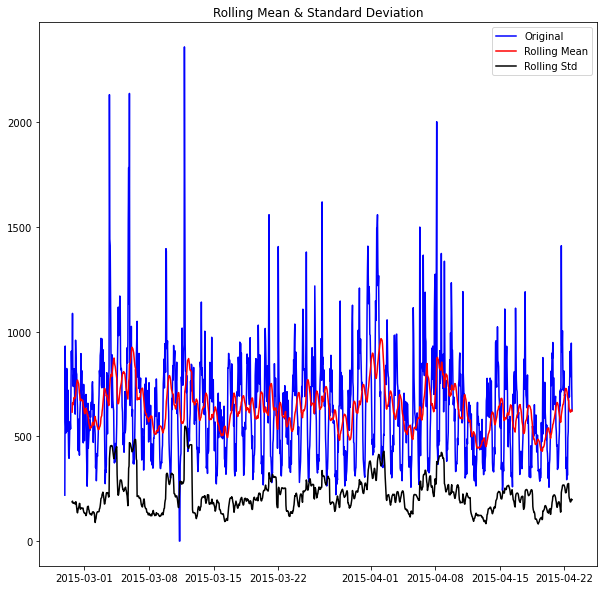

In [546]:
plt.figure(figsize = (10,10))
test_stationarity(df_hourly_count.head(2000))
plt.savefig('Rolling.png', dpi=1000)

First, we can see that the rolling mean, and the rolling std are horizontal, but seems to have some trends. This give us a hint that the time series may be stationary.

The test statistic is smaller than the 5% critical values so we can say with 95% confidence that this is a stationary series. Moreover, as the p-value is inferior to the 5% threshold, the null hypothesis is rejected, meaning that the Dickey-Fuller test is verified. Thus, the time series is stationary.

Let's see if we can find an even more stationary time series by applying some transformations. First, let's substract the rolling mean:

Results of Dickey-Fuller Test:
Test Statistic                   -5.342171
p-value                           0.000004
#Lags Used                       23.000000
Number of Observations Used    1296.000000
Critical Value (1%)              -3.435406
Critical Value (5%)              -2.863773
Critical Value (10%)             -2.567959
dtype: float64


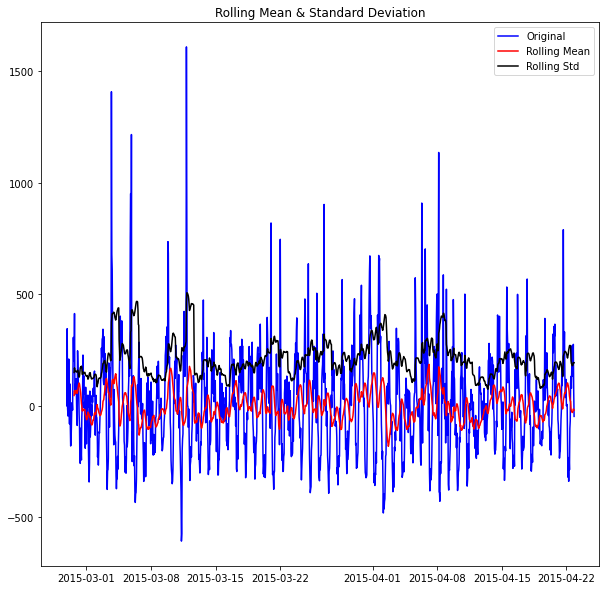

In [548]:
rolling_mean_exp_decay = df_hourly_count.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_hourly_count_decay = df_hourly_count - rolling_mean_exp_decay
df_hourly_count_decay.dropna(inplace=True)
plt.figure(figsize = (10,10))
test_stationarity(df_hourly_count_decay)
plt.savefig('Rolling_tuned.png', dpi=1000)

We can observe that this time series is even more stationary with a lower p-value.

### OGA Implementation

Let suppose $y_{t}^{\pi}$ denotes the amount of cloud resources planned, and $x_{t}$ the unknown demand.

The reward function adds a quadratic penalty whenever the demand exceeds the planned resource:

$$f_{t}(y_{t}) = -0.1 y_{t} - 0.5*(x_{t} - y_{t})^{2}* 1_{x_{t} > y_{t}} $$

Let's compute the directional derivative:

$$\frac{\partial f_{t}(y_{t})}{\partial y_{t}} = -0.1 - (x_{t} - y_{t})* 1_{x_{t} > y_{t}} $$

Then, the algorithm is resources planned in the following way:

$$ y_{t+1} = (y_{t} + \eta ( (x_{t} - y_{t})1_{x_{t} > y_{t}} - 0.1))^{+}$$

where $\eta$ is the stepsize.

We train our model as follow:

#### Split Data (train set and test set)


In [527]:
#Split the data set between the training set and the test set
T_train = len(df_hourly_count) - int(7 * 24) #7*24 for the last two week (test set)
train = df_hourly_count_decay.values[:T_train]
test = df_hourly_count_decay.values[T_train:]

#### OGA algorithm

In [528]:
def OGA(original_data, eta):
    '''
    Input:
        original_data (array): actual outcomes
        eta: (float) stepsize
    '''
    y = 0 #Initialize y
    predictions = np.zeros(len(original_data))
    for t in range(len(original_data)):
        x = original_data[t]
        if x > y:
            y = max(0, y + eta*((x - y) - 0.1))
        else:
            y = max(0, y - eta*0.1)
        predictions[t] = y
    return predictions

#### Results

In [529]:
eta = 1
predictions_train = OGA(train, eta)

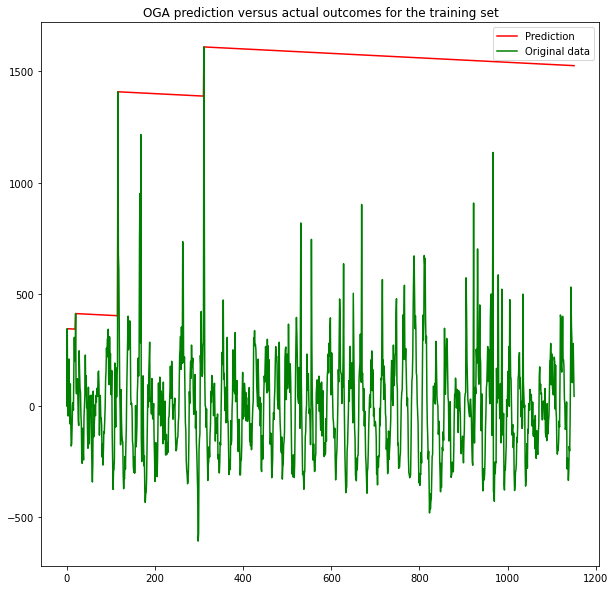

In [530]:
plt.figure(figsize = (10,10))
plt.plot(predictions_train, 'r', label='Prediction')
plt.plot(train, 'g', label='Original data')
plt.title('OGA prediction versus actual outcomes for the training set')
plt.legend(loc='upper right')

In [531]:
def display_cost_reward(original_data, predictions):
    '''
    Input:
        original_data (array): actual outcomes
        predictions (array): predictions
    Output: print cumulative penaltie, cost, and reward
    '''
    penalty = 0
    base_cost = 0
    cumulative_reward = 0
    for i in range(len(original_data)):
        base_cost += 0.1*predictions[i]
        penalty += 0.5*(max(0,original_data[i] - predictions[i]))**2
    cumulative_reward = -base_cost - penalty
    print('penalty:',penalty)
    print('base cost', base_cost)
    print('cumulative reward', cumulative_reward)

In [532]:
display_cost_reward(train, predictions_train)

penalty: 0.019999999999986355
base cost 163667.30916755533
cumulative reward -163667.32916755532


We now test our model:

In [533]:
predictions_test = OGA(test, eta)

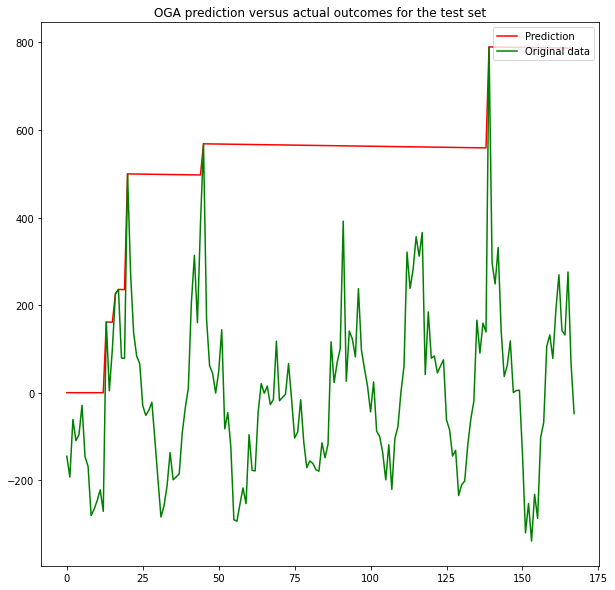

penalty: 0.030000000000005116
base cost 8972.116467316162
cumulative reward -8972.146467316163


In [534]:
plt.figure(figsize = (10,10))
plt.plot(predictions_test, 'r', label='Prediction')
plt.plot(test, 'g', label='Original data')
plt.title('OGA prediction versus actual outcomes for the test set')
plt.legend(loc='upper right')
plt.savefig('OGA_tuned.png', dpi=1000)
plt.show()
display_cost_reward(test, predictions_test)

Finally, we can compare the model to the original time series.

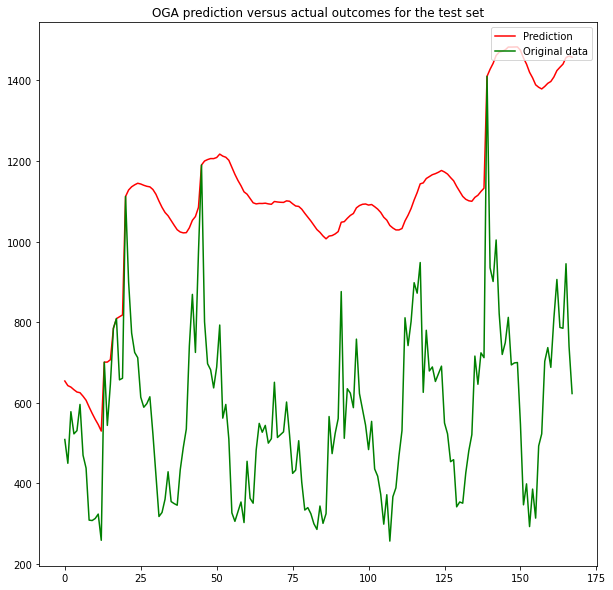

In [535]:
plt.figure(figsize = (10,10))
plt.plot(predictions_test + rolling_mean_exp_decay.values[T_train:], 'r', label='Prediction')
plt.plot(df_hourly_count.values[T_train:], 'g', label='Original data')
plt.title('OGA prediction versus actual outcomes for the test set')
plt.legend(loc='upper right')
plt.savefig('OGA.png', dpi=1000)

We found out that we tend to allocate way more resources than necessary. When their is a spike, resources called out increases tremendously. Thus, for a well chosen eta (here eta = 1), most of the time, we have enough resource, however the amount of resources called up and unused is quite high. Hence, Online Gradient Ascend technique is not optimal in this particular scenario. Let's try to implement Auto-Regressive Integrated Moving Average (ARIMA) forecast to get better ressults.

## ARIMA

In [536]:
# evaluate an ARIMA model using a walk-forward validation
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

#Forecast for the training set
history = [x for x in train]
predictions_train = list()
# walk-forward validation
for t in range(len(train)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions_train.append(yhat)
    obs = train[t]
    history.append(obs)
# evaluate forecasts: root mean squared error score (RMSE) for the predictions
rmse = sqrt(mean_squared_error(train, predictions_train))
print('Train RMSE: %.3f' % rmse)

Train RMSE: 174.806


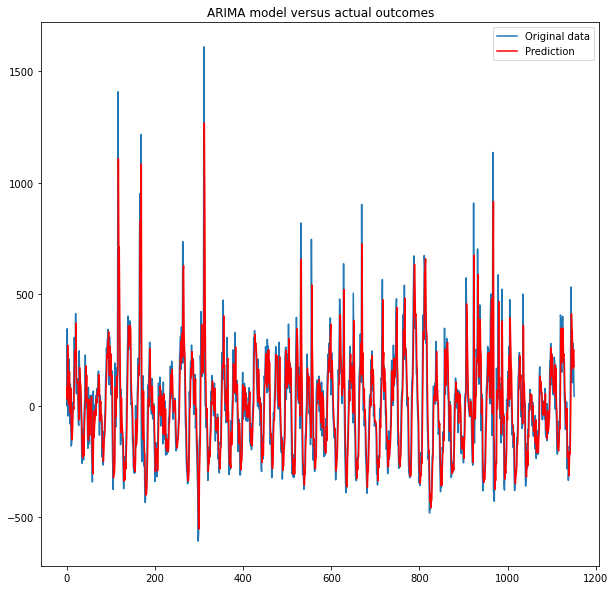

penalty: 9603734.955161573
base cost 141.8994640347838
cumulative reward -9603876.854625609


In [537]:
# plot forecasts against actual outcomes for the training set
plt.figure(figsize = (10,10))
plt.plot(train,label='Original data')
plt.plot(predictions_train, color='red',label='Prediction')
plt.legend(loc='best')
plt.title('ARIMA model versus actual outcomes')
plt.savefig('ARIMA_train.png', dpi=1000)
plt.show()
display_cost_reward(train, predictions_train)

In [538]:
# evaluate an ARIMA model using a walk-forward validation
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

#Forecast for the test set
history = [x for x in train]
predictions_test = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions_test.append(yhat)
    obs = test[t]
    history.append(obs)
#     print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts: root mean squared error score (RMSE) for the predictions
rmse = sqrt(mean_squared_error(test, predictions_test))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 128.014


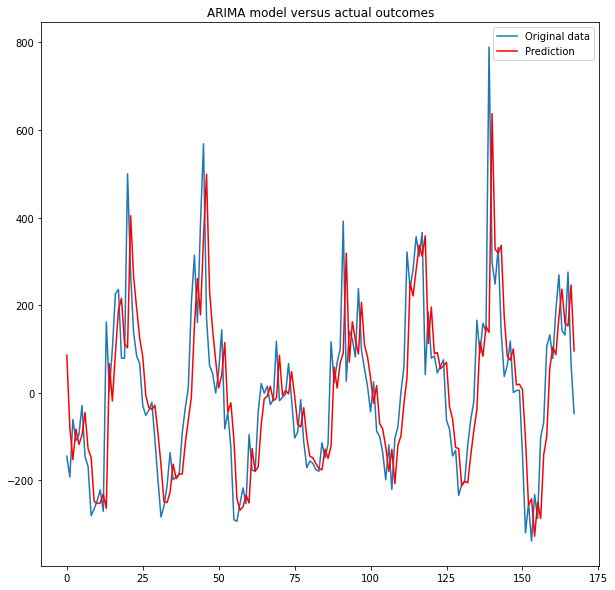

penalty: 806399.274483468
base cost 26.466828227156277
cumulative reward -806425.7413116952


In [539]:
# plot forecasts against actual outcomes for the test set
plt.figure(figsize = (10,10))
plt.plot(test,label='Original data')
plt.plot(predictions_test, color='red',label='Prediction')
plt.legend(loc='best')
plt.title('ARIMA model versus actual outcomes')
plt.savefig('ARIMA_test.png', dpi=1000)
plt.show()
display_cost_reward(test, predictions_test)

We can see that the prediction is quite accurate. Yet, there is an offset between predictions and actual outcomes, and predictions are often below actual outcomes. This can result in very high user experience penalty as seen above.

To counter those issues, let's add a positive constant value. By doing so, we can counter times when there is a shift in cloud resource demand.

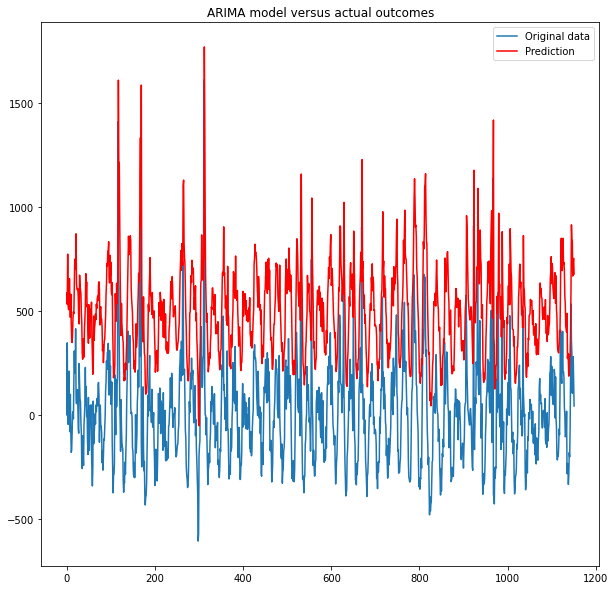

penalty: 915655.8616969218
base cost 57741.89946403488
cumulative reward -973397.7611609567


In [540]:
cst = 500 # Constant to be added to predictions
predictions_train_tuned = [x + cst for x in predictions_train]

# plot forecasts against actual outcomes
plt.figure(figsize = (10,10))
plt.plot(train,label='Original data')
plt.plot(predictions_train_tuned, color='red',label='Prediction')
plt.legend(loc='best')
plt.title('ARIMA model versus actual outcomes')
plt.show()
display_cost_reward(train, predictions_train_tuned)

We can conclude that adding a constant value to predictions is highly benificial for our reward functions. As expected, the penalty is tremendously reduced (by a factor 10 for cst = 500), and we can see on the figure above that most of the time we manage to deal with shifts in cloud resource demand. In order to find the most suitable value for this constant, let's loop over this constant, and compute cumulative rewards:

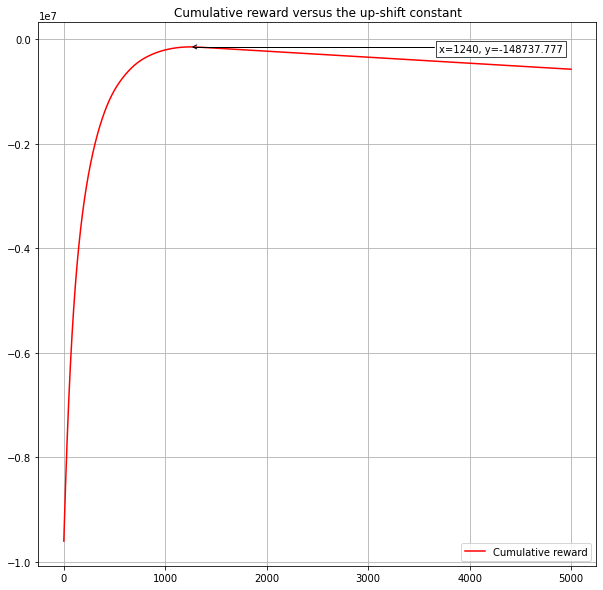

In [541]:
csts = np.arange(start=0,stop=5000,step=1) # Constants to be added to predictions
cumulative_reward = np.zeros(len(csts))

for k in range (len(csts)):
    predictions_train_tuned = [x + csts[k] for x in predictions_train]
    penalty = 0
    base_cost = 0
    for i in range(len(train)):
        base_cost += 0.1*predictions_train_tuned[i]
        penalty += 0.5*(max(0,train[i] - predictions_train_tuned[i]))**2
    cumulative_reward[k] = -base_cost - penalty


fig, ax = plt.subplots(figsize=(10,10))

ax.plot(csts, cumulative_reward, color='r',label='Cumulative reward')
plt.legend(loc='lower right')
plt.title('Cumulative reward funcion of the constant added')

def annot_max(x,y, ax=None):
    ymax = max(y)
    xmax = np.argmax(y)
    text= "x={}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=60,angleB=0")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

annot_max(csts, cumulative_reward)
plt.title('Cumulative reward versus the up-shift constant')
plt.grid()
plt.savefig('ARIMA_cumulative_rwd.png', dpi=1000)
plt.show()

We obtain the highest cumulative reward for a constant equal to 1240.

See below, the result we obtain for the training set when we use a constant equal to 1240.

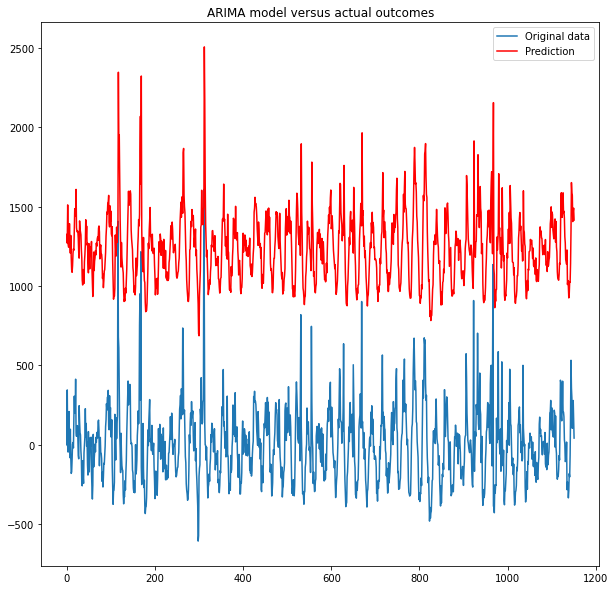

penalty: 5747.877188740465
base cost 142989.89946403474
cumulative reward -148737.7766527752


In [542]:
cst = 1240 # Constant to be added to predictions
predictions_train_tuned = [x + cst for x in predictions_train]

# plot forecasts against actual outcomes
plt.figure(figsize = (10,10))
plt.plot(train,label='Original data')
plt.plot(predictions_train_tuned, color='red',label='Prediction')
plt.legend(loc='best')
plt.title('ARIMA model versus actual outcomes')
plt.savefig('ARIMA_train_tuned.png', dpi=1000)
plt.show()
display_cost_reward(train, predictions_train_tuned)

See below, the result we obtain for the test set when we use a constant equal to 1240.

We now apply ARIMA, with the up-shift constant equal to 1240, and we obtain the following figure.

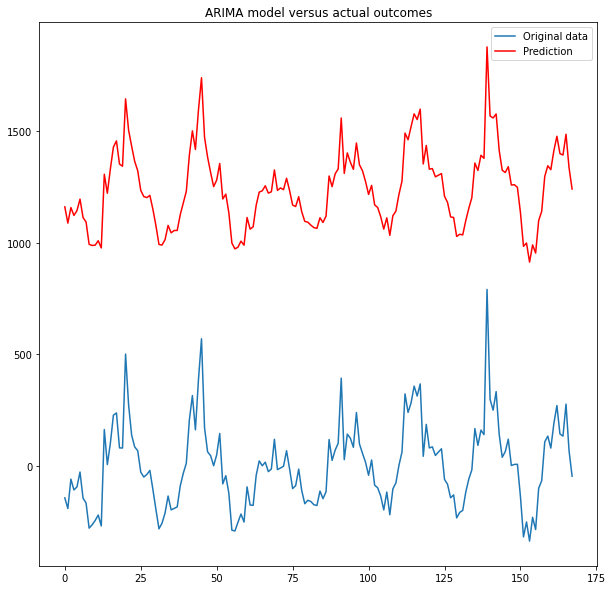

penalty: 0.0
base cost 20849.88886742561
cumulative reward -20849.88886742561


In [543]:
cst = 1240 # Constant to be added to predictions
predictions_test_tuned_v2 = [x + cst for x in predictions_test_tuned]

# plot forecasts against actual outcomes
plt.figure(figsize = (10,10))
plt.plot(test,label='Original data')
plt.plot(predictions_test_tuned_v2, color='red',label='Prediction')
plt.legend(loc='best')
plt.title('ARIMA model versus actual outcomes')
plt.savefig('ARIMA_test_tuned.png', dpi=1000)
plt.show()
display_cost_reward(test, predictions_test_tuned_v2)

Finally, we can compare the model to the original time series.

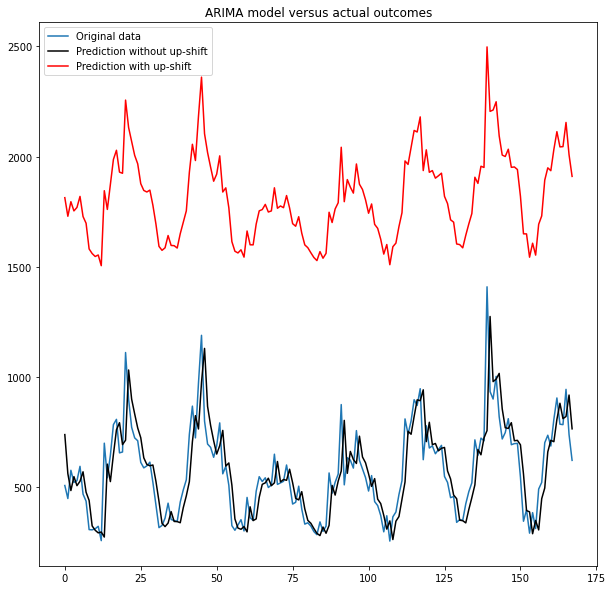

penalty: 0.0
base cost 30473.876572350993
cumulative reward -30473.876572350993


In [554]:
predictions_original = predictions_test_tuned_v2 + rolling_mean_exp_decay.values[T_train:]
true_test = df_hourly_count.values[T_train:]

# plot forecasts against actual outcomes
plt.figure(figsize = (10,10))
plt.plot(true_test,label='Original data')
plt.plot(predictions_test+ rolling_mean_exp_decay.values[T_train:], color='k',label='Prediction without up-shift')
plt.plot(predictions_original, color='red',label='Prediction with up-shift')
plt.legend(loc='best')
plt.title('ARIMA model versus actual outcomes')
plt.savefig('ARIMA_test_tuned_original.png', dpi=1000)
plt.show()
display_cost_reward(test, predictions_original)

We can conclude that adding a constant value to predictions is highly benificial for our reward function. As expected, the penalty is tremendously reduced, and we can see on the figure above that we manage to deal with shifts in cloud resource demand.